# 라이브러리

In [3]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn.functional as F
from torch import nn, optim, cuda
from torch.utils import data
from torchvision import datasets, transforms
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
import itertools
from model_GH import GH
from model_GH import pointnetloss
import pickle

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class GH_Dataset(torch.utils.data.Dataset): 
    def __init__(self,X,Y):
        self.x_data = torch.from_numpy(X).type(dtype=torch.float32)
        self.y_data = torch.tensor(Y).resize_(len(X),1)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx): 
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

In [10]:
path = "/home/inhamath/dacon"

with open(path + "/GH_DACON_2022_08/train_dataset.pickle", 'rb') as f:
    train_dataset = pickle.load(f)

with open(path + "/GH_DACON_2022_08/test_dataset.pickle", 'rb') as f:
    test_dataset = pickle.load(f)

batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size)
del train_dataset
del test_dataset

model = GH()
model.load_state_dict(torch.load("/home/inhamath/dacon/GH_DACON_2022_08/model_state/50,0.0014.pt"))
device = 'cuda' if cuda.is_available() else 'cpu'
model.to(device)
criterion = pointnetloss
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output, m3x3, m64x64 = model(data.permute(0,2,1))
        pred = output.data.max(1, keepdim=True)[1]
        all_preds += list(pred.cpu().numpy())
        all_labels += list(target.cpu().numpy())

Normalized confusion matrix


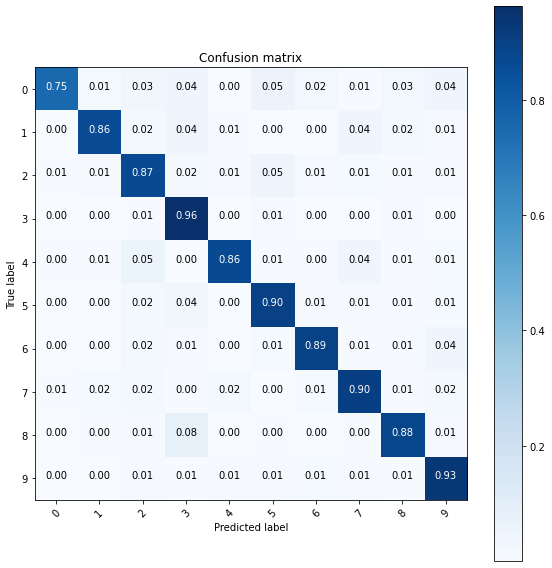

In [12]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(all_labels, all_preds), [i for i in range(10)], normalize=True)